In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
stock_data = pd.read_csv('datacsv/002210.csv')
stock_data = stock_data.set_index('date')
stock_data.index = pd.to_datetime(stock_data.index)
stock_data = stock_data.sort_index(axis=0, ascending=True)

In [3]:
DA = 6
stadate = '20110101'
enddate = '20170731'

In [4]:
LLV_min = stock_data['close'].rolling(window=DA).min()
HHV_max = stock_data['close'].rolling(window=DA).max()

In [5]:
HHV_LLV = pd.concat([stock_data['close'], LLV_min, HHV_max], axis=1)
HHV_LLV.columns = ['close','LLV','HHV']

In [6]:
HHV_LLV['ABS'] = np.abs(HHV_LLV['HHV']/HHV_LLV['LLV']-1)
HHV_LLV['MAX'] = HHV_LLV['ABS'].rolling(window=DA).max()

In [7]:
HHV_LLV['DA'] = DA
HHV_LLV.loc[HHV_LLV['MAX']>0.1,'DA'] = 3

In [8]:
HHV_LLV['MM'] = HHV_LLV['close'].rolling(window=DA).mean()
HHV_LLV.loc[HHV_LLV['DA'] == 3,'MM'] = HHV_LLV['close'].rolling(window=3).mean()
HHV_LLV['M1'] = HHV_LLV['MM'].shift(1)

In [9]:
HHV_LLV = HHV_LLV[pd.to_datetime(HHV_LLV.index) >= pd.to_datetime(stadate)]
HHV_LLV = HHV_LLV[pd.to_datetime(HHV_LLV.index) <= pd.to_datetime(enddate)]

In [10]:
HHV_LLV.tail()

,close,LLV,HHV,ABS,MAX,DA,MM,M1
date,,,,,,,,
2017-07-25,10.92,9.94,10.92,0.098592,0.098592,6,10.385000,10.228333
2017-07-26,10.79,9.94,10.92,0.098592,0.098592,6,10.511667,10.385000
2017-07-27,11.13,10.03,11.13,0.109671,0.109671,3,10.946667,10.511667
2017-07-28,10.95,10.50,11.13,0.060000,0.109671,3,10.956667,10.946667
2017-07-31,10.97,10.79,11.13,0.031511,0.109671,3,11.016667,10.956667


In [11]:
Buy_Point = HHV_LLV.loc[HHV_LLV['close'] > HHV_LLV['M1'],['close','MM','M1']]
Buy_Point.loc[0:,'point'] = 1
Buy_Point.columns = ['Buy_close','Buy_MM','Buy_M1','Buy_point']

In [12]:
Sell_Point = HHV_LLV.loc[HHV_LLV['close'] < HHV_LLV['M1'],['close','MM','M1']]
Sell_Point.loc[0:,'point'] = -1
Sell_Point.columns = ['Sell_close','Sell_MM','Sell_M1','Sell_point']

In [13]:
Strategy_data = pd.concat([Buy_Point, Sell_Point], axis=1)
Strategy_data = Strategy_data.fillna(0)
Strategy_data['Points'] = Strategy_data['Buy_point']+Strategy_data['Sell_point']
Strategy_point_data = pd.concat([HHV_LLV, Strategy_data['Points']], axis=1)

In [14]:
k = len(Strategy_point_data)
Strategy_point_data['order'] = np.arange(0,k,1)
Strategy_point_data.loc[k-1:k,'Points'] = -1

In [15]:
Strategy_point_data['BS_point'] = Strategy_point_data['Points'].shift(1)
Strategy_point_data['BS_point'] = Strategy_point_data['BS_point'].fillna(-1)
Strategy_point_data['BS_point'] = (Strategy_point_data['Points'] - Strategy_point_data['BS_point'])/2+Strategy_point_data['Points']

In [16]:
BP_price = Strategy_point_data.loc[Strategy_point_data['BS_point'] == 2, ['order','close','M1','BS_point']]
SP_price = Strategy_point_data.loc[Strategy_point_data['BS_point'] == -2, ['order','close','M1','BS_point']]

In [17]:
BP_price['startdate'] = BP_price.index
BP_Profit = BP_price[['startdate','close','M1']]
BP_Profit.columns = ['Start_date','Buy_close','Buy_M1']
BP_Profit = BP_Profit.reset_index(drop=True)

In [18]:
SP_price['enddate'] = SP_price.index
SP_Profit = SP_price[['enddate','close','M1']]
SP_Profit.columns = ['End_date','Sell_close','Sell_M1']
SP_Profit = SP_Profit.reset_index(drop=True)

In [19]:
Strategy_Profit = pd.concat([BP_Profit, SP_Profit], axis=1, join_axes=[BP_Profit.index])
Strategy_Profit = Strategy_Profit[['Start_date','End_date','Buy_close','Sell_close','Buy_M1','Sell_M1']]

In [20]:
p = len(Strategy_Profit)
cash = 10000
Strategy_Profit.loc[0:0,'Startcash'] = cash
Startcash = Strategy_Profit['Startcash'][0]
batch = 100
brokerage = 2.5
Strategy_Profit.head()

,Start_date,End_date,Buy_close,Sell_close,Buy_M1,Sell_M1,Startcash
0,2011-01-04,2011-01-06,2.33,2.25,2.293333,2.326667,10000.0
1,2011-01-27,2011-02-22,1.96,2.05,1.933333,2.118333,NaN
2,2011-02-24,2011-03-10,2.12,2.16,2.111667,2.201667,NaN
3,2011-03-14,2011-03-18,2.20,2.20,2.196667,2.201667,NaN
4,2011-03-24,2011-03-31,2.18,2.19,2.166667,2.203333,NaN


In [21]:
Strategy_Profit.loc[0:0,'Shares'] = (Startcash/batch)//Strategy_Profit['Buy_M1']*batch
Strategy_Profit.loc[0:0,'Price'] = Strategy_Profit['Buy_M1']*Strategy_Profit['Shares']
bb = Strategy_Profit['Price'][0]*brokerage/10000
if bb > 5:
    Strategy_Profit.loc[0:0,'Buy_Brokerage'] = bb
else:
    Strategy_Profit.loc[0:0,'Buy_Brokerage'] = 5
# ===============================================
Strategy_Profit.loc[0:0,'Surplus'] = Strategy_Profit['Startcash'] - Strategy_Profit['Price'] - Strategy_Profit['Buy_Brokerage']
Strategy_Profit.loc[0:0,'AlphaCat'] = Strategy_Profit['Sell_M1']*Strategy_Profit['Shares']
sb = Strategy_Profit['AlphaCat'][0]*brokerage/10000
if bb > 5:
    Strategy_Profit.loc[0:0,'Sell_Brokerage'] = sb
else:
    Strategy_Profit.loc[0:0,'Sell_Brokerage'] = 5
Strategy_Profit.loc[0:0,'Tax'] = Strategy_Profit['AlphaCat']*1.0/1000
Strategy_Profit.loc[0:0,'Endcash'] = Strategy_Profit['AlphaCat'] + Strategy_Profit['Surplus'] - Strategy_Profit['Sell_Brokerage'] - Strategy_Profit['Tax']
Strategy_Profit.loc[1:1,'Startcash'] = Strategy_Profit['Endcash'][0]


In [22]:
for i in range(1,p):
    Strategy_Profit.loc[i:i,'Shares'] = (Strategy_Profit['Startcash']/batch)//Strategy_Profit['Buy_M1']*batch
    Strategy_Profit.loc[i:i,'Price'] = Strategy_Profit['Buy_M1']*Strategy_Profit['Shares']
    bbr = Strategy_Profit['Price']*brokerage/10000
    if bbr[i-1] > 5:
        Strategy_Profit.loc[i:i,'Buy_Brokerage'] = bbr[i-1]
    else:
        Strategy_Profit.loc[i:i,'Buy_Brokerage'] = 5
    Strategy_Profit.loc[i:i,'Surplus'] = Strategy_Profit['Startcash'] - Strategy_Profit['Price'] - Strategy_Profit['Buy_Brokerage']
    Strategy_Profit.loc[i:i,'AlphaCat'] = Strategy_Profit['Sell_M1']*Strategy_Profit['Shares']
    sbr = Strategy_Profit['AlphaCat']*brokerage/10000
    if sbr[i-1] > 5:
        Strategy_Profit.loc[i:i,'Sell_Brokerage'] = sbr[i-1]
    else:
        Strategy_Profit.loc[i:i,'Sell_Brokerage'] = 5
    Strategy_Profit.loc[i:i,'Tax'] = Strategy_Profit['AlphaCat']*1.0/1000
    Strategy_Profit.loc[i:i,'Endcash'] = Strategy_Profit['AlphaCat'] + Strategy_Profit['Surplus'] - Strategy_Profit['Sell_Brokerage'] - Strategy_Profit['Tax']
    Strategy_Profit.loc[i+1:i+1,'Startcash'] = Strategy_Profit['Endcash'][i]

In [23]:
Strategy_Profit['Profit_real'] = Strategy_Profit['Endcash']/cash

In [24]:
Strategy_Profit_Small = Strategy_Profit[['Start_date','End_date','Buy_M1','Sell_M1','Startcash','Shares','Price','Surplus','AlphaCat','Endcash','Profit_real']]
Strategy_Profit_Small.tail().round(3)

,Start_date,End_date,Buy_M1,Sell_M1,Startcash,Shares,Price,Surplus,AlphaCat,Endcash,Profit_real
196,2017-06-19,2017-06-21,10.063,10.072,2.387569e+07,2372500.0,2.387526e+07,-5536.116,2.389503e+07,2.385962e+07,2385.962
197,2017-06-26,2017-06-28,10.038,10.040,2.385962e+07,2376800.0,2.385911e+07,-5459.148,2.386307e+07,2.382778e+07,2382.778
198,2017-06-29,2017-07-11,10.020,10.375,2.382778e+07,2378000.0,2.382756e+07,-5748.755,2.467175e+07,2.463536e+07,2463.536
199,2017-07-13,2017-07-17,10.402,10.457,2.463536e+07,2368400.0,2.463531e+07,-5900.496,2.476557e+07,2.472874e+07,2472.874
200,2017-07-21,2017-07-31,10.162,10.957,2.472874e+07,2433500.0,2.472842e+07,-5839.330,2.666305e+07,2.662435e+07,2662.435


In [25]:
Strategy_Profit_plt = Strategy_Profit[['Start_date','Profit_real']]
Strategy_Profit_plt = Strategy_Profit_plt.set_index('Start_date')

In [26]:
plt.figure(2,figsize=(14,4), dpi=80)
ax1 = plt.subplot(111)

In [27]:
Strategy_Profit_plt['Profit_real'].plot(color='red', alpha=1)

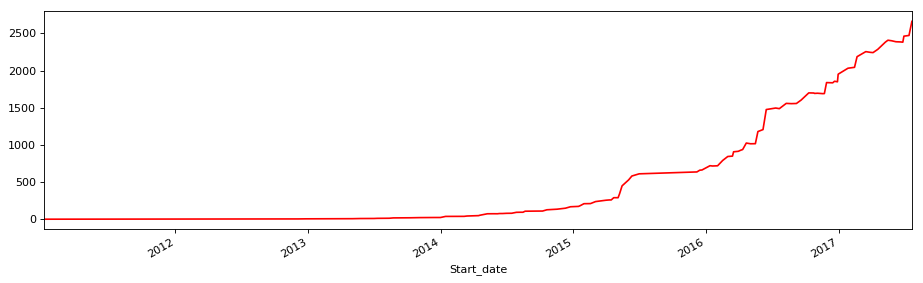

In [28]:
plt.show()

In [29]:
Profit = Strategy_Profit_plt.tail(1)['Profit_real'].values
print '策略总收益率：',
print Profit[0].round(3),
print '倍'

策略总收益率： 2662.435 倍


In [30]:
StartClose = Strategy_point_data.head(1)['close'].values
EndClose = Strategy_point_data.tail(1)['close'].values
ProfitClose = (EndClose[0] - StartClose[0])/StartClose[0]*100
print '基准收益率：',
print ProfitClose.round(3),
print '％'

基准收益率： 370.815 ％


In [31]:
SZ_data = pd.read_csv('datacsv/SZ000000.csv')
SZ_data = SZ_data.set_index('date')
SZ_data.index = pd.to_datetime(SZ_data.index)
SZ_data = SZ_data.sort_index(axis=0, ascending=True)
SZ_data = SZ_data[pd.to_datetime(SZ_data.index) >= pd.to_datetime(stadate)]
SZ_data = SZ_data[pd.to_datetime(SZ_data.index) <= pd.to_datetime(enddate)]
StartSZ = SZ_data.head(1)['close'].values
EndSZ = SZ_data.tail(1)['close'].values
ProfitSZ = (EndSZ[0] - StartSZ[0])/StartSZ[0]*100
print '上证收益率：',
print ProfitSZ.round(3),
print '％'

上证收益率： 14.736 ％
